# Twitter Sentiment Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import ensemble
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech
!unzip twitter-sentiment-analysis-hatred-speech.zip

Dataset URL: https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
License(s): unknown
  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 135MB/s]
Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


## Load Datasets

In [ ]:
train_set = pd.read_csv('train.csv', encoding='utf-8', engine='python', header=0)
test_set = pd.read_csv('test.csv', encoding='utf-8', engine='python', header=0)

In [ ]:
# view training data
train_set.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
# view testing data
test_set.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [ ]:
# shapes of both sets
print("Train set shape: {} and test set shape: {}".format(train_set.shape, test_set.shape))

Train set shape: (31962, 3) and test set shape: (17197, 2)


In [ ]:
# general info about train set
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
# check for duplicated values
print('There are {} duplicated values in train_set'.format(train_set.duplicated().sum()))

There are 0 duplicated values in train_set


In [ ]:
# num of classes of 'label' variable of train set
train_set.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


## Imbalanced Dataset: SMOTE and Random Undersampling

### Clean and Process Dataset

In [ ]:
# convert uppercase to lowercase in tweets
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
# delete punctuation marks
train_set['tweet'] = train_set['tweet'].str.replace('[^\w\s]', '')
test_set['tweet'] = test_set['tweet'].str.replace('[^\w\s]', '')

In [ ]:
# delete numbers
train_set['tweet'] = train_set['tweet'].str.replace('\d','')
test_set['tweet'] = test_set['tweet'].str.replace('\d','')

In [ ]:
# delete stopwords
sw = stopwords.words("english")
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

In [ ]:
# lemmatization
train_set['tweet'] = train_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
test_set['tweet'] = test_set['tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [ ]:
# drop 'id' column
train_set = train_set.drop("id", axis = 1)
test_set = test_set.drop("id", axis = 1)

In [ ]:
# view training and testing data
train_set.head()

,label,tweet
0,0,@user father dysfunctional selfish drag kid dy...
1,0,@user @user thanks #lyft credit can't use caus...
2,0,bihday majesty
3,0,#model love u take u time urð±!!! ððð...
4,0,factsguide: society #motivation


In [ ]:
test_set.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone see n...
2,safe way heal #acne!! #altwaystoheal #healthy ...
3,"hp cursed child book reservation already? yes,..."
4,"3rd #bihday amazing, hilarious #nephew eli ahm..."


In [ ]:
# divide datasets
x = train_set["tweet"]
y = train_set["label"]

train_x, test_x, train_y, test_y = model_selection.train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

## Vectorization

In [ ]:
train_x.iloc[987]

'@user @user problem aol available mobile phone :( u notice user r using mail mobiles.'

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

x_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
len(x_train_count.toarray())

25569

In [ ]:
len(train_x)

25569

### "TF-IDF" Method

In [ ]:
tf_idf_word_vectorizer = TfidfVectorizer()
tf_idf_word_vectorizer.fit(train_x)

x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

x_train_tf_idf_word.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Build Machine Learning Models

**Logistic Regression**

With 'count-vectors' method:

In [ ]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print("\nLogistic regression model with 'count-vectors' method")
print(f"Accuracy ratio: {accuracy}")


Logistic regression model with 'count-vectors' method
Accuracy ratio: 0.9488504114420065


With 'tf-idf' method:

In [ ]:
log = linear_model.LogisticRegression()
log_model = log.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(log_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(f"Accuracy: {accuracy}")

Accuracy: 0.9305520180250783


**XGBoost**

With 'count-vectors' method:

In [ ]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_count, train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_count,
                                           test_y,
                                           cv = 20).mean()

print(f"Accuracy: {accuracy}")

Accuracy: 0.9419719827586208


With 'tf-idf' method:

In [ ]:
xgb = XGBClassifier()
xgb_model = xgb.fit(x_train_tf_idf_word, train_y)
accuracy = model_selection.cross_val_score(xgb_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(f"Accuracy: {accuracy}")

Accuracy: 0.9389983346394984


**Light GBM**

With 'count-vectors' method:

In [ ]:
lgbm = LGBMClassifier()
lgbm_model = lgbm.fit(x_train_tf_idf_word,train_y)
accuracy = model_selection.cross_val_score(lgbm_model,
                                           x_test_tf_idf_word,
                                           test_y,
                                           cv = 20).mean()

print(f"Accuracy: {accuracy}")

[LightGBM] [Info] Number of positive: 1764, number of negative: 23805
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.258904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40283
[LightGBM] [Info] Number of data points in the train set: 25569, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.068990 -> initscore=-2.602312
[LightGBM] [Info] Start training from score -2.602312
[LightGBM] [Info] Number of positive: 454, number of negative: 5619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6987
[LightGBM] [Info] Number of data points in the train set: 6073, number of used features: 384
[LightGBM] [Info] [

**ROC AUC**

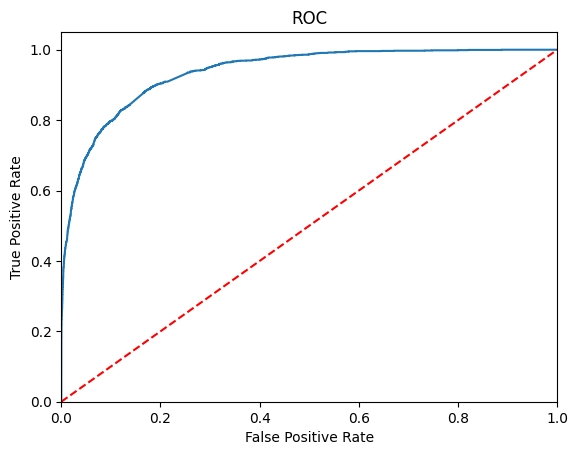

In [ ]:
y = train_y
X = x_train_count.astype("float64")

logit_roc_auc = roc_auc_score(y, lgbm_model.predict(X))

fpr, tpr, thresholds = roc_curve(y, lgbm_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='AUC (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

## Estimation Over Test Set

In [ ]:
test_set.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone see n...
2,safe way heal #acne!! #altwaystoheal #healthy ...
3,"hp cursed child book reservation already? yes,..."
4,"3rd #bihday amazing, hilarious #nephew eli ahm..."


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(train_x)
test_set = vectorizer.transform(test_set["tweet"])
test_set.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
lgbm_model.predict(test_set.astype("float"))[0:5]

array([0, 1, 0, 0, 0])